In [10]:
import os
import shutil
import requests
import tarfile

from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio.v3 as iio

from sklearn.preprocessing import LabelEncoder
from dataclasses import dataclass, asdict

import torch
import torchvision
import torchmetrics

import torchdata.datapipes as dp
from torch.utils.data import DataLoader

torchvision.disable_beta_transforms_warning();
from torchvision.models import alexnet, AlexNet_Weights
import torchvision.transforms.v2 as t

from lightning import LightningModule, LightningDataModule, Trainer, seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger, WandbLogger

import wandb

from tqdm import tqdm
from typing import Callable, Any
from dotenv import load_dotenv
load_dotenv();

from hyperparameters import Hyperparameters

import logging
logging.getLogger("lightning.pytorch").setLevel(logging.ERROR)

In [11]:
IMAGENETTE = Path.home() / "datasets" / "imagenette"

CHECKPOINTS_DIR = Path.cwd() / "checkpoints"
CHECKPOINTS_DIR.mkdir(exist_ok=True)

LOGS_DIR = Path.cwd() / "logs"
LOGS_DIR.mkdir(exist_ok=True)

In [12]:
def viz_batch(batch: tuple[torch.Tensor, torch.Tensor], le: LabelEncoder, df: pd.DataFrame) -> None:
    images, targets = batch
    labels = le.inverse_transform(targets.ravel())
    labels = [df.loc[x].label for x in labels]
    assert images.shape[0] == targets.shape[0], "#images != #targets"

    subplot_dims:tuple[int, int]
    if images.shape[0] <= 8:
        subplot_dims = (1, images.shape[0])
    else:
        subplot_dims = (int(np.ceil(images.shape[0]/8)), 8)

    figsize = 20
    figsize_factor = subplot_dims[0] / subplot_dims[1]
    _, axes = plt.subplots(nrows = subplot_dims[0], 
                           ncols = subplot_dims[1], 
                           figsize = (figsize, figsize * figsize_factor))
    for idx, ax in enumerate(axes.ravel()):
        ax.imshow(images[idx].permute(1, 2, 0))
        ax.tick_params(axis = "both", which = "both", 
                       bottom = False, top = False, 
                       left = False, right = False,
                       labeltop = False, labelbottom = False, 
                       labelleft = False, labelright = False)
        ax.set_xlabel(f"{labels[idx]}({targets[idx].item()})")

In [13]:
class ImageDataLoader(dp.iter.IterDataPipe):
    def __init__(self, 
                 src_dp: dp.iter.IterDataPipe, 
                 label_encoder: LabelEncoder,
                 transform: Callable | None = None):
        self.src_dp  = src_dp 
        self.le = label_encoder
        self.transform = transform if transform else self._default_transform
    
    def __iter__(self): 
        for path, label in self.src_dp:
            image = self._load_image(path)
            #image = self._minmax_image(image)
            image = self.transform(image) #type: ignore
            label = self._encode_label(label)
            yield (image, label)
     
    def _load_image(self, image_path: Path) -> torch.Tensor:
        image = (iio.imread(uri = image_path,
                           plugin = "pillow",
                           extension = ".jpg")
                    .squeeze())

        #Duplicate Grayscale Image
        if image.ndim == 2:
            image = np.stack((image,)*3, axis = -1)
        assert image.shape[-1] == 3, "Not A 3 Channel Image"
        return image

    def _encode_label(self, label) -> torch.Tensor:
        return torch.tensor(
            self.le.transform([label])[0], #type: ignore
        dtype = torch.long)
    
    def _minmax_image(self, image: torch.Tensor) -> torch.Tensor:
        return (image - image.min()) / (image.max() - image.min())
    
    def _default_transform(self, image: torch.Tensor | np.ndarray) -> torch.Tensor:
        return t.Compose([
            t.ToImage(),
            t.ToDtype(torch.float32, scale=True),
            t.Resize((256, 256), antialias=True),
        ])(image)

In [14]:
class ImagenetteDataModule(LightningDataModule):
    def __init__(self, root: Path, params: Hyperparameters, transform: Callable | None = None) -> None:
        super().__init__()
        self.root = root
        if not self.root.is_dir():
            self.root.mkdir(parents = True)
        self.transform = transform
        self.batch_size = (params.batch_size // params.grad_accum)

        #TODO: Figure out how to automate getting num_workers
        #os.cpu_count or something like that
        self.num_workers = params.num_workers

        self.save_hyperparameters(params.get_datamodule_dict(),
            ignore = ["transform", "params"])

    def prepare_data(self) -> None:
        if self._is_empty_dir(self.root):
            url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz"  
            print("Root is Empty, Downloading Dataset")
            archive: Path = self.root / "archive.tgz"
            self._download_from_url(url, archive)
            print("Extracting Dataset")
            self._extract_tgz(archive, self.root)
            print("Deleting Archive")
            archive.unlink(missing_ok=True)
            print("Moving Items to Root")
            self._move_dir_up(self.root / "imagenette2")
            print("Done!")
    
    def setup(self, stage: str) -> None:
        self._setup_local()
        if stage == "fit":
            self.train_dataset = self._prepare_local_train()
            self.val_dataset = self._prepare_local_val() 
        
        elif stage == "validate":
            self.val_dataset = self._prepare_local_val()

        elif stage == "test":
            self.val_dataset = self._prepare_local_val()

        elif stage == "predict":
            self.val_dataset = self._prepare_local_val()
        
    def train_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset = self.train_dataset, 
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            #persistent_workers = True,
            pin_memory = True,
            shuffle = True
            )

    def val_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset = self.val_dataset, 
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            pin_memory = True
            )

    def test_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset = self.val_dataset, 
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            )

    def predict_dataloader(self) -> DataLoader:
        return DataLoader(
            dataset = self.val_dataset, 
            batch_size = self.batch_size,
            num_workers = self.num_workers,
            )

    def _setup_local(self) -> None:
        df = pd.read_csv(self.root/"noisy_imagenette.csv")
        df = df[["path", "is_valid"]]
        df["path"] = df["path"].apply(lambda x: IMAGENETTE / x)
        df["label"] = df["path"].apply(lambda x: x.parent.stem)

        self.val_df = (df[df["is_valid"] == True]
                .drop(columns=["is_valid"])
                .sort_values("label")
                .reset_index(drop=True))

        self.train_df = (df[df["is_valid"] == False]
                .drop(columns=["is_valid"])
                .sort_values("label")
                .reset_index(drop=True))

        self._prepare_label_encoder(df["label"].unique())

    def _prepare_local_train(self) -> Any:
        pipe = self._datapipe_from_dataframe(self.train_df)
        pipe = (pipe 
                    .shuffle(buffer_size=len(self.train_df))
                    #.sharding_filter()
                    #.pinned_memory()
                    #.load_image_data()
                    #.prefetch()
                    #.set_length()
                )
        pipe = ImageDataLoader(pipe, self.label_encoder, self.transform) #type:ignore 
        pipe = pipe.prefetch(self.batch_size)
        pipe = pipe.set_length(len(self.train_df))
        return pipe

    def _prepare_local_val(self) -> Any:
        pipe = self._datapipe_from_dataframe(self.val_df)
        pipe = ImageDataLoader(pipe, self.label_encoder, self.transform) #type: ignore
        pipe = pipe.set_length(len(self.val_df))
        return pipe

    def _datapipe_from_dataframe(self, dataframe: pd.DataFrame) -> Any:
        return dp.iter.Zipper(
            dp.iter.IterableWrapper(dataframe.path),
            dp.iter.IterableWrapper(dataframe.label)
            )
    
    def _prepare_label_encoder(self, class_names: list) -> None:
        self.label_encoder = LabelEncoder().fit(sorted(class_names))

    def _download_from_url(self, url: str, local_filename: Path) -> None:
        response = requests.head(url)
        file_size = int(response.headers.get("Content-Length", 0))

        with requests.get(url, stream=True) as response:
            with open(local_filename, "wb") as output_file:
                with tqdm(
                    total=file_size, unit="B", unit_scale=True, unit_divisor=1024
                ) as progress_bar:
                    for data in response.iter_content(chunk_size=1024*1024):
                        output_file.write(data)
                        progress_bar.update(len(data))
    
    def _extract_tgz(self, tgz_file, out_dir) -> None: 
        with tarfile.open(tgz_file, "r:gz") as tar:
            tar.extractall(out_dir)
        
    def _is_empty_dir(self, path: Path) -> bool:
        return not list(path.iterdir())
        
    def _move_dir_up(self, source_dir: Path) -> None:
        for path in source_dir.iterdir():
            dest_path = source_dir.parent / path.name
            if path.is_dir():
                path.rename(dest_path)
            else:
                shutil.move(path, dest_path)
        source_dir.rmdir()

In [15]:
class ClassificationModel(LightningModule):
    def __init__(self, model, params: Hyperparameters):
        super().__init__()
        self.model = model
        self.params = params
        #TODO : Add dicts for Metrics, Optimizers, Criterions
        #TODO : Remove Dependence on Hyperparameters Class, locally store stuff

        self._set_metrics()
        self.save_hyperparameters(
            {i:params.get_litmodule_hparams()[i] 
             for i in params.get_litmodule_hparams().keys() if i!='criterion'},
            ignore = ["model", "params", "num_workers"]
        ) 
    
    def forward(self, batch):
        x, _ = batch
        return self.model(x)

    def _forward_pass(self, batch, metrics : Callable | None = None):
        x, y = batch
        y_pred = self.model(x)
        if metrics:
            metrics.update(y_pred, y) 
        return self.params.criterion(y_pred, y) #type: ignore

    def _set_metrics(self):
        #self.train_metrics = torchmetrics.Accuracy("multiclass", 
                                    #num_classes=self.params.num_classes,
                                    #average = "macro")

        self.test_metrics = torchmetrics.MetricCollection(
            {"acc": torchmetrics.Accuracy("multiclass",
                                    num_classes=self.params.num_classes, 
                                    average = "macro"),

             "f1" : torchmetrics.F1Score("multiclass",
                                    num_classes=self.params.num_classes,
                                    average = "macro")},
            prefix = "test_"
        )
        self.test_confm = torchmetrics.ConfusionMatrix(
            task = "multiclass", num_classes = self.params.num_classes,
        )
        #self.val_metrics = torchmetrics.Accuracy("multiclass",
                                    #num_classes=self.params.num_classes, 
                                    #average = "macro")

    def training_step(self, batch, batch_idx):
        loss = self._forward_pass(batch)
        self.log("train_loss", loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._forward_pass(batch)#, self.val_metrics)
        self.log("val_loss", loss, on_step = False, on_epoch = True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.model(x)
        #loss = self.params.criterion(y_pred, y)
        #self.log("test_loss", loss, on_step=False, on_epoch=True)
        #self.log_dict(self.test_metrics)
        self.test_metrics.update(y_pred, y)
        self.test_confm.update(y_pred, y)
    
    def on_test_epoch_end(self):
        self.log_dict(self.test_metrics.compute())
        self.test_metrics.reset()

        self.test_confm.compute()
        self.test_confm.plot()
        self.test_confm.reset()
    
    def configure_optimizers(self):
        return self.params.optimizer(self.model.parameters(), #type: ignore
                                     lr = self.params.learning_rate,
                                     #momentum = 0.9, weight_decay = 5e-4
                                     )

In [16]:
local_checkpoint = ModelCheckpoint(
    dirpath=CHECKPOINTS_DIR,
    filename="{epoch}-{train_loss:2f}-{val_loss:2f}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=True,
)

local_logger = CSVLogger(
    save_dir=Path.cwd(),
    name="logs",
    version=1,
)

#wandb.finish()
#wandb_logger = WandbLogger(
    #save_dir=LOGS_DIR,
    #project="ilsvrc-with-imagenette",
    #log_model=True,
    #version='2',
#)

In [17]:
experiment = Hyperparameters(
    task = "multiclass_classification",
    random_seed = 42,
    num_classes = 10,
    metrics = ["accuracy", "f1score"],

    criterion = torch.nn.CrossEntropyLoss(),
    optimizer = torch.optim.Adam,
    learning_rate = 1e-8,
    momentum = 0,
    weight_decay = 0,

    batch_size = 128,
    grad_accum = 4,
    test_split = .3,
    transform = ["resize_256, random_crop_224"],
    num_workers = 8,

)

seed_everything(experiment.random_seed, workers = True);
alexnet_pretrained = alexnet(weights = "DEFAULT")
alexnet_pretrained.classifier[-1] = torch.nn.Linear(
                                        in_features=4096,
                                        out_features=experiment.num_classes,
                                        bias = True) 

alexnet_transform = t.Compose([
    t.ToImage(),
    t.ToDtype(torch.float32, scale = True),
    t.Resize(size = (256, 256), antialias = True),
    t.RandomCrop(size = (224, 224), pad_if_needed = True),
    #t.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]),
    #t.RandomHorizontalFlip(p = .5)
])

classifier = ClassificationModel(alexnet_pretrained, experiment)
imagenette_dm = ImagenetteDataModule(
        root = IMAGENETTE, 
        params = experiment, 
        transform = alexnet_transform)

Seed set to 42


In [28]:
trainer = Trainer(
    #fast_dev_run=True,
    #num_sanity_val_steps=10,
    #deterministic=True,
    #benchmark=True,
    #enable_checkpointing=False,
    callbacks=[local_checkpoint],
    logger=[local_logger],

    max_epochs = 36,
    accumulate_grad_batches = experiment.grad_accum,
    check_val_every_n_epoch = 4
)

last_ckpt = CHECKPOINTS_DIR / "last.ckpt"
last_ckpt = last_ckpt if last_ckpt.is_file() else None

In [21]:
#trainer.fit(
    #model = classifier,
    #datamodule = imagenette_dm,
    #ckpt_path = last_ckpt #type: ignore
#)

In [22]:
classifier = ClassificationModel(alexnet_pretrained, experiment)
trainer.test(
    model=classifier,
    datamodule=imagenette_dm,
    ckpt_path=last_ckpt
)

/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:196: Experiment logs directory /home/sambhav/dev/ilsvrc/logs/version_1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.27981728315353394    │
│          test_f1          │    0.2821311354637146     │
└───────────────────────────┴───────────────────────────┘

[{'test_acc': 0.27981728315353394, 'test_f1': 0.2821311354637146}]

In [29]:
preds = trainer.predict(
    model=classifier,
    dataloaders=imagenette_dm,
    return_predictions=True,
    ckpt_path=last_ckpt
) 

/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:196: Experiment logs directory /home/sambhav/dev/ilsvrc/logs/version_1 exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
/home/sambhav/miniconda3/envs/dev/lib/python3.11/site-packages/lightning/pytorch/utilities/data.py:121: Your `IterableDataset` has `__len__` defined. In combination with multi-process data loading (when num_workers > 1), `__len__` could be inaccurate if each worker is not configured independently to avoid having duplicate data.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [22]:
#imagenette_dm.setup("predict")
#dm = imagenette_dm.val_dataloader()
#labels_l = list()
#for batch in dm:
    #labels_l += batch[1].tolist()
#labels_l = [batch[1] for batch in dm]
#del dm

#labels_t = torch.stack(labels_l[:-1]).argmax(dim=2).flatten()
#labels_t = torch.cat([
    #labels_t,    
    #torch.tensor(labels_l[-1].argmax(dim=1))
#])

In [26]:
df = imagenette_dm.val_df
df["label_i"] = imagenette_dm.label_encoder.transform(df["label"])

labels_t = torch.tensor(df.label_i)

In [30]:
confm = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=10)
acc_micro = torchmetrics.Accuracy(task = "multiclass", num_classes=10, average="micro")
acc_macro = torchmetrics.Accuracy(task = "multiclass", num_classes=10, average="macro")

preds_l = list()
for pred in preds:
    preds_l += pred.argmax(axis = 1).tolist()
preds_t = torch.tensor(preds_l)[:3925]

imagenette_dm.setup("predict")
df = imagenette_dm.val_df
df["label_i"] = imagenette_dm.label_encoder.transform(df["label"])
labels_t_ = torch.tensor(df.label_i)

print(labels_t.shape)
print(preds_t.shape)

confm.update(preds_t, labels_t)
acc_micro.update(preds_t, labels_t)
acc_macro.update(preds_t, labels_t)

torch.Size([3925])
torch.Size([3925])


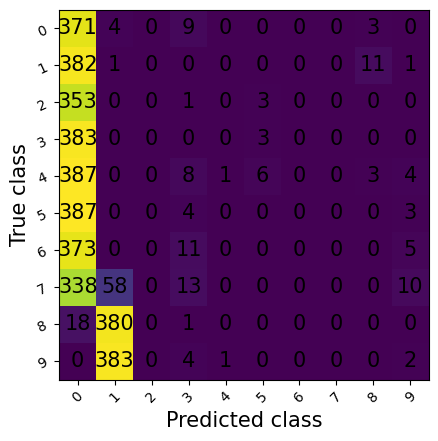

In [31]:
confm.plot()
plt.show()

In [33]:
pd.Series(preds_t).value_counts()

0    2992
1     826
3      51
9      25
8      17
5      12
4       2
Name: count, dtype: int64